In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (18,9)

In [2]:
columns = ['Time', 'Distance', 'Y', 'Label']
data = pd.read_csv('../contagens/itapoa-01.csv', names=columns)

data['Y'] = data['Y'].fillna(0)
data['Label'] = data['Label'].fillna('')
data['Time'] = data['Time'] - data['Time'].min()
data['Blocked'] = data['Distance'] < 8000
data['Distance'] = data['Distance'] * data['Blocked']
data[80:100]

,Time,Distance,Y,Label,Blocked
80,1893,0,0.0,,False
81,1916,0,0.0,,False
82,1941,0,0.0,,False
83,1964,0,0.0,,False
84,1988,1244,0.0,,True
85,2012,1176,0.0,,True
86,2036,1246,0.0,,True
87,2060,1207,0.0,,True
88,2084,1220,0.0,,True
89,2108,1185,0.0,,True


## Momentum algorithm

Applying momentum algorithm on the distance readings.
This algorithm take in account the previous values on the time series to avaluate the current values.

Notes: Momentum performs poorly due to the high noise in the samples. Reducing the noise in the samples could have a positive effect in this algorithm as well as other. 

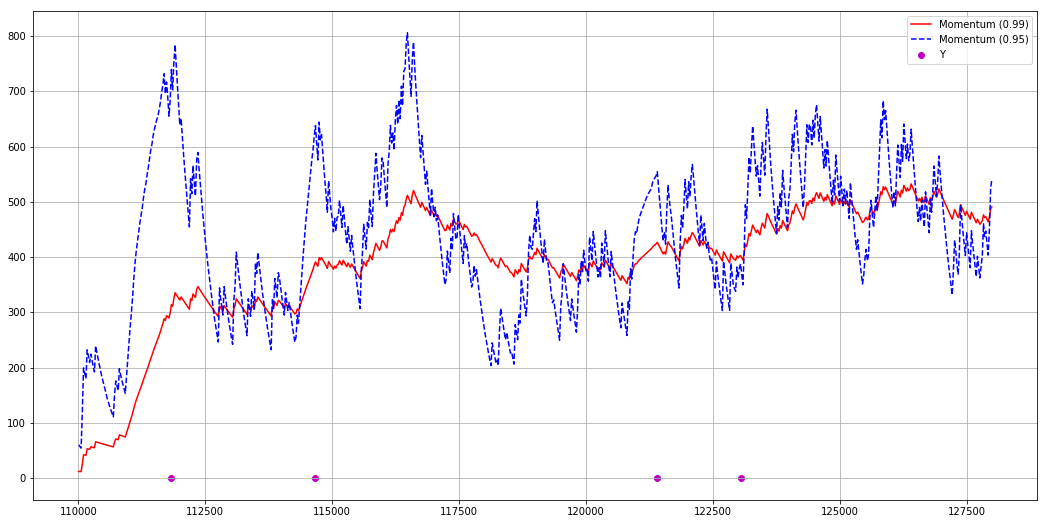

In [8]:
acm = 0
def momentum(distance, beta):
    global acm
    # 0.99 * 100 + 0.01 * 1000 = 99 + 10
    acm = acm * beta + (1 - beta) * distance 
    return acm

time_window = 0.3 * 60 * 1000
time_start = 110000
time_end = time_start + time_window

sample = data[(data.Time > time_start) & (data.Time <= time_end)].copy()
Y = sample[sample.Y == 1].copy()

plt.scatter(Y['Time'], Y['Y'], marker='o', color='m')

acm = 0
plt.plot(sample['Time'], sample['Distance'].apply(momentum, args=(0.99,)), 'r', label='Momentum (0.99)')

acm = 0
plt.plot(sample['Time'], sample['Distance'].apply(momentum, args=(0.95,)), 'b--', label='Momentum (0.95)')

# acm = 0
# plt.plot(sample['Time'], sample['Distance'].apply(momentum, args=(0,)), 'g--', label='Momentum (0.00)')


plt.grid(True)
plt.legend();

## Averaging

Simple average of the past $n$ values.

Note: Also performs poorly on noisy data.

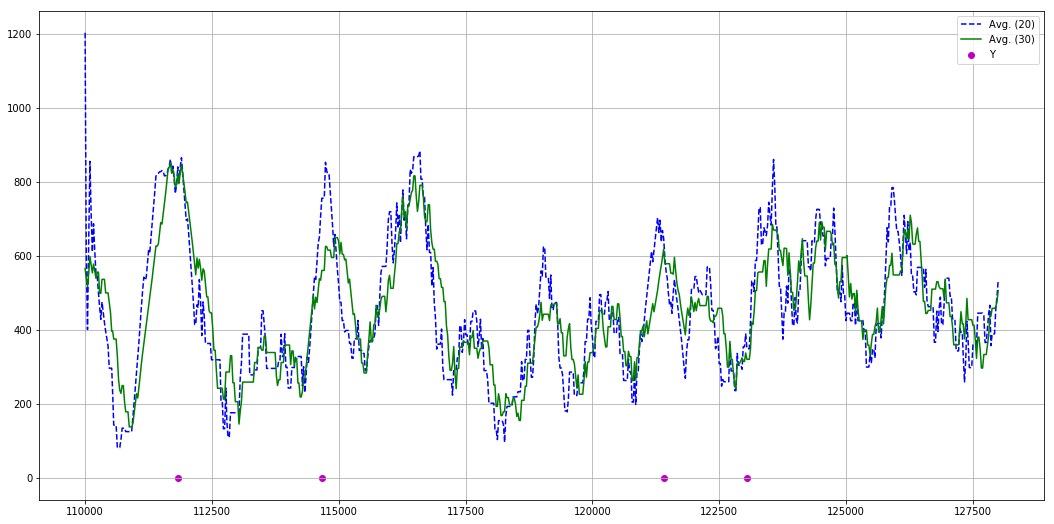

In [4]:
cache = list()
def average(distance, n):
    cache.append(distance)
    if len(cache) > n:
        cache.pop(0)
    return sum(cache) / len(cache)


time_window = 0.3 * 60 * 1000
time_start = 110000
time_end = time_start + time_window

sample = data[(data.Time > time_start) & (data.Time <= time_end)].copy()
Y = sample[sample.Y == 1].copy()

plt.scatter(Y['Time'], Y['Y'], marker='o', color='m')

plt.plot(sample['Time'], sample['Distance'].apply(average, args=(20,)), 'b--', label='Avg. (20)')
plt.plot(sample['Time'], sample['Distance'].apply(average, args=(30,)), 'g', label='Avg. (30)')

plt.grid(True)
plt.legend();

By evaluating the two algorithms (momentum and average) it's clear that whatever argorithm used in this noisy data will performs poorly.

## Final algorithm

The folowing algorithm is intended to handle the issue of noise data seen in the previous algorithms.

Basically, all the non-continous data/stream smaller than $n$ will be discarted and all streams greather tham this threshold will be considered as a positive prediction.

In [17]:
dist = list()
def predict(distance, n):
    global dist
    # Testing if the sensor is blocked by something
    if distance > 0:
        # Addind the read distance to the dist list(caching distance)
        dist.append(distance)
        return False
    
    # Inplicit else: Nothing blocking the sensor

    # Positive if cache is greather than 'n' else negative (possible noise) 
    ret = len(dist) >= n    
    
    # Cleaning cache for future processing
    dist = list()
    
    # Return prediction
    return ret

data['Predict'] = data['Distance'].apply(predict, args=(9,))

data[data.Predict]

,Time,Distance,Y,Label,Blocked,Predict
97,2295,0,0.0,,False,True
1746,41545,0,0.0,,False,True
3638,86438,0,0.0,,False,True
4701,111712,0,0.0,,False,True
4827,114692,0,0.0,,False,True
5110,121428,0,0.0,,False,True
5645,134169,0,0.0,,False,True
5717,135856,0,0.0,,False,True
6076,144384,0,0.0,,False,True
6992,166234,0,0.0,,False,True


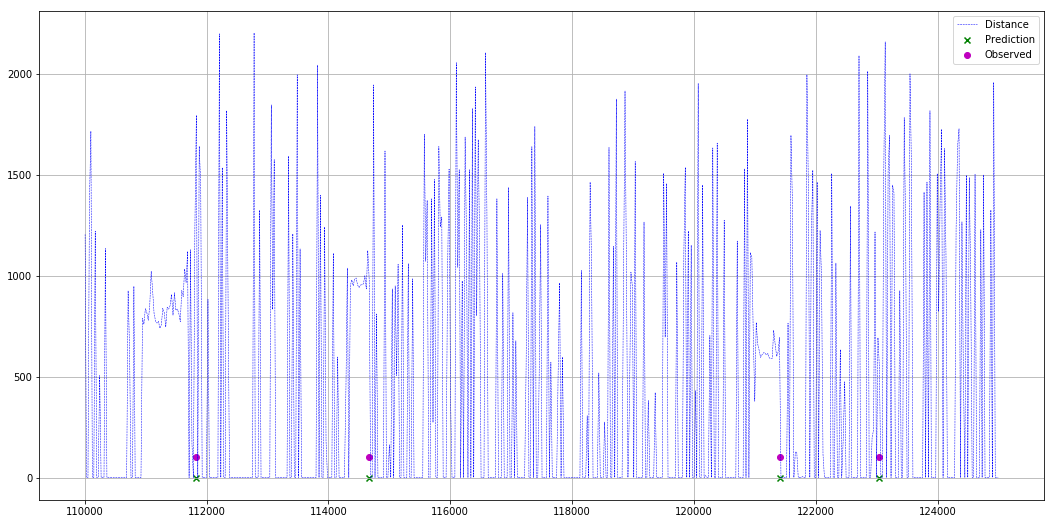

In [9]:
time_window = 0.25 * 60 * 1000
time_start = 110000
time_end = time_start + time_window

sample = data[(data.Time > time_start) & (data.Time <= time_end)].copy()
Y = sample[sample.Y == 1].copy()

plt.scatter(Y['Time'], Y['Predict'], marker='x', color='g', label='Prediction')
plt.scatter(Y['Time'], Y['Y'] * 100, marker='o', color='m', label='Observed')

plt.plot(sample['Time'], sample['Distance'], 'b--', linewidth=0.5, label='Distance')

plt.grid(True)
plt.legend();

In [20]:
start = 8503 # Falso positivo
# start = 8780 # Falso positivo
w = 30
data[start - w: start + w]

,Time,Distance,Y,Label,Blocked,Predict
8473,201508,0,0.0,,False,False
8474,201532,0,0.0,,False,False
8475,201555,0,0.0,,False,False
8476,201580,0,0.0,,False,False
8477,201603,0,0.0,,False,False
8478,201628,1220,0.0,,True,False
8479,201651,0,0.0,,False,False
8480,201675,0,0.0,,False,False
8481,201700,841,0.0,,True,False
8482,201723,1132,0.0,,True,False
